In [32]:
import mdtraj as md
import mido
from mido import Message, MidiFile, MidiTrack, MetaMessage
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import List
import pandas as pd

In [152]:
EPS = 1e-5
def raw_rmsd(traj: md.Trajectory, atom_ixs: List[np.ndarray], frame_ix: int = 0) -> List[np.ndarray]: 
    results = []
    for atom_ix in atom_ixs:
        xyz = traj.xyz[:, atom_ix, :]
        rmsd = np.sqrt(np.mean(np.sum((xyz - xyz[frame_ix])**2, axis=-1), axis=-1))
        results.append(rmsd)
        
    return results
    
def digitize(traj: np.ndarray, n_notes: int = None, bins: np.ndarray = None) -> List[np.ndarray]: 

    if bins is None:
        bins = np.linspace(traj.min()-EPS, traj.max()+EPS, n_notes)

    return np.digitize(traj, bins)

    # return results

def floor_multiple(x, m): 
    return np.floor(x/m)*m

def ceil_multiple(x, m): 
    return np.ceil(x/m)*m


In [108]:
def target_shift(notes: pd.Series, target_note: int, target_frame: int = -1): 
    diff = target_note - notes.iloc[target_frame]
    notes = notes + diff
    assert notes.iloc[target_frame] == target_note
    return notes



VMD representations you might want:
1. resname 4G1 4G2 4G3 4G4 4G5 4G7  (just biochar)
2. resname DCPAA (just 2,4-D)
3. resname SOL NA CL (if you want to see solvent/ions etc.)

In [21]:
# targets
target_frames = 3000 # set by what is interesting to observe
target_length = 60 # set by what listener can endure

# Frames per second - which will certainly not be represented in music.  
fps = target_frames/target_length
print('frames per second (video) ', fps)

# We need to subset these frames for the musical notes to occur on a more reasonable timescale.  e.g., 120 bpm. 
bpm = 120
bps = bpm/60
n_beats = target_length*bps
print('total number of beats = ', n_beats, ' with bpm = ', bpm)

# We'll assume that there are 5 ticks to a beat to make it interesting (and for the stride to be a whole number). Each tick corresponds to a frame. 
ticks_per_beat = 5
n_ticks = n_beats*ticks_per_beat
print('total number of ticks = ', n_ticks, ' with ticks_per_beat = ', ticks_per_beat)

# With this many ticks we can set the subsetting rate: 
stride = target_frames/n_ticks
print('stride = ', stride)
assert int(stride) == stride
stride = int(stride)

frames per second (video)  50.0
total number of beats =  120.0  with bpm =  120
total number of ticks =  600.0  with ticks_per_beat =  5
stride =  5.0


In [22]:
traj_all = md.load('reimaged_trajectory/24D_BC400s3_no_nump.xtc', top='reimaged_trajectory/24D_BC400s3.gro')

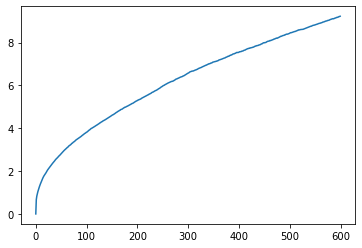

In [23]:
traj = traj_all[:target_frames:stride]
traj = traj.atom_slice(traj.top.select('mass > 2'))

traj.superpose(traj)
plt.plot(md.rmsd(traj,traj))

In [24]:
sol_res_ix = [x.index  for x in traj.top.residues if x.name[:5] == 'DCPAA']
sol_res_ix = [sol_res_ix[i] for i in [1, 3, 8, 15, 20, 16, 49, 52, 74, 94]]
atom_ix = dict(
    not_water = [traj.top.select('not water')], 
    all_solute = [traj.top.select('resname DCPAA')], 
    biochar = [traj.top.select("resname =~ '4G*'")], 
    solute = [traj.top.select(f"resid {i}") for i in sol_res_ix]
)

## Create features

In [153]:
rmsds_by_ix = {k: raw_rmsd(traj, v) for k, v in atom_ix.items()}
rmsds_by_ix_flat = {f"{k}-{i}": v[i] for k, v in rmsds_by_ix.items() for i in range(len(v)) }

In [154]:
features = pd.DataFrame.from_dict(rmsds_by_ix_flat)
features.columns = [f"rmsd-{x}" for x in features.columns]
features.columns

Index(['rmsd-not_water-0', 'rmsd-all_solute-0', 'rmsd-biochar-0',
       'rmsd-solute-0', 'rmsd-solute-1', 'rmsd-solute-2', 'rmsd-solute-3',
       'rmsd-solute-4', 'rmsd-solute-5', 'rmsd-solute-6', 'rmsd-solute-7',
       'rmsd-solute-8', 'rmsd-solute-9'],
      dtype='object')

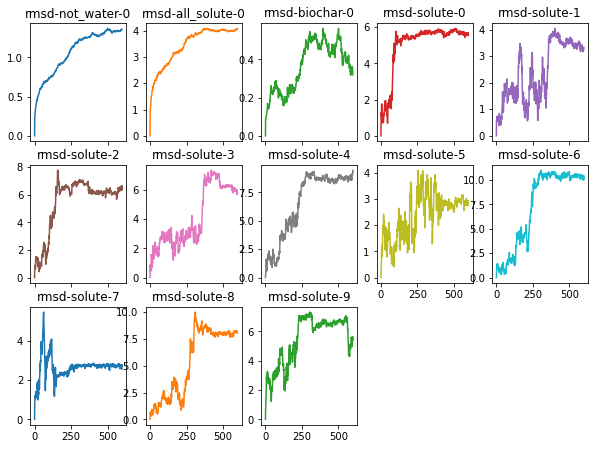

In [155]:
_ = features.plot(subplots=True, layout=(4,5), figsize=(10, 10), title=list(features.columns), legend=False)

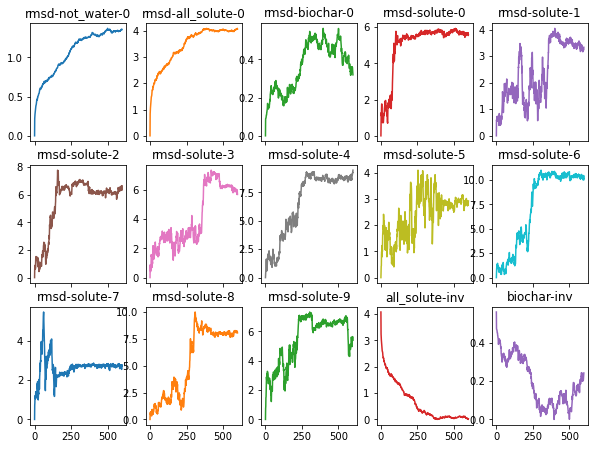

In [156]:
features['all_solute-inv'] = features['rmsd-all_solute-0'].max() - features['rmsd-all_solute-0']
features['biochar-inv'] = features['rmsd-biochar-0'].max() - features['rmsd-biochar-0']

# features['biochar-fluc'] = features['rmsd-biochar-0'].diff()


_ = features.plot(subplots=True, layout=(4,5), figsize=(10, 10), title=list(features.columns), legend=False)

## Digitize

We can digitize based on each trajectory (so they all have the same range of values), or we can digitize based on the global spread of values. 

In [158]:
n_notes = 50
# notes = features.transform(lambda x: digitize(x, n_notes=n_notes), axis=0)
# notes

bins = np.linspace(features.values.flatten().min()-EPS, features.values.flatten().max()+EPS, n_notes)
notes = features.transform(lambda x: digitize(x, bins=bins), axis=0)
notes

,rmsd-not_water-0,rmsd-all_solute-0,rmsd-biochar-0,rmsd-solute-0,rmsd-solute-1,rmsd-solute-2,rmsd-solute-3,rmsd-solute-4,rmsd-solute-5,rmsd-solute-6,rmsd-solute-7,rmsd-solute-8,rmsd-solute-9,all_solute-inv,biochar-inv
0,1,1,1,1,1,1,1,1,1,1,1,1,1,19,3
1,1,4,1,4,3,3,4,2,2,3,4,3,4,15,3
2,2,5,1,6,3,4,4,3,2,5,4,3,4,14,3
3,2,5,1,5,3,4,3,5,3,5,6,3,7,14,3
4,2,6,1,7,4,3,2,5,4,5,5,2,7,14,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,7,19,2,25,15,30,26,41,13,45,12,36,25,1,1
596,7,19,2,26,15,29,26,41,13,46,12,37,26,1,1
597,7,19,2,26,15,29,27,42,13,45,13,37,26,1,2
598,7,19,2,25,15,30,26,42,13,47,13,37,26,1,2


## Harmonize

![notes](logic-midi-note-numbers.png)

In [138]:
notes.columns

Index(['rmsd-not_water-0', 'rmsd-all_solute-0', 'rmsd-biochar-0',
       'rmsd-solute-0', 'rmsd-solute-1', 'rmsd-solute-2', 'rmsd-solute-3',
       'rmsd-solute-4', 'rmsd-solute-5', 'rmsd-solute-6', 'rmsd-solute-7',
       'rmsd-solute-8', 'rmsd-solute-9', 'all_solute_inv', 'biochar-fluc',
       'all_solute-inv', 'biochar-inv'],
      dtype='object')

In [143]:
CMAJOR = [24, 28, 43, 48, 52, 55, 60]

def harmonize_df(df: pd.DataFrame, chord: List[int], target_frame: int=-1) -> pd.DataFrame:
    notes_harm = pd.concat([target_shift(df[col], target_note = chord[i%len(chord)], target_frame=target_frame)
                            for i, col in enumerate(df)], axis=1)
    return notes_harm
        

def shift_df(df: pd.DataFrame, lowest_note: int=0) -> pd.DataFrame:
    min_val = df.min().min()
    diff = lowest_note - min_val
    df = df + diff
    return df


# harmonize the 

use_features = ['rmsd-solute-0', 'rmsd-solute-1', 'rmsd-solute-3', 'rmsd-solute-5', 'rmsd-solute-7', 'rmsd-solute-9', 
                'rmsd-all_solute-0', 'rmsd-biochar-0', 
                'all_solute-inv', 'biochar-inv' ]
harmonized_notes = harmonize_df(notes.loc[:, use_features], chord=CMAJOR)
harmonized_notes = shift_df(harmonized_notes)

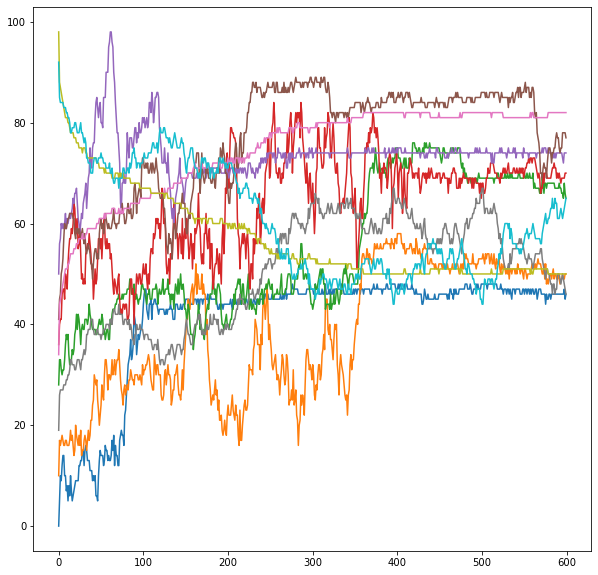

In [148]:
_ = harmonized_notes.plot(subplots=False, figsize=(10, 10), legend=False)

## Create MidiFile

In [149]:
mid = MidiFile()
mid.ticks_per_beat = ticks_per_beat


for col in use_features:
        
        # Setup track
        track = MidiTrack()
        mid.tracks.append(track)
        track.append(MetaMessage('set_tempo', tempo=mido.bpm2tempo(bpm), time=0))
        track.append(Message('program_change', time=0))
        
        # Get notes
        note_list = harmonized_notes[col]
        
        # First note
        track.append(Message('note_on', time=0, note=int(note_list[0])))
        
        # Loop notes
        duration = 1
        for t in range(1, len(note_list)):
            
            new_note = note_list[t]
            old_note = note_list[t-1]
            if new_note != old_note: 
                track.append(Message('note_off', time=duration, note=int(old_note)))
                track.append(Message('note_on', time=0, note=int(new_note)))
                duration = 1
            else: 
                duration += 1
        
        track.append(Message('note_off', time=4*ticks_per_beat, note=int(new_note)))
        
mid.save('day_in_life_version_1.mid')

# Notes


Larger number of frames but stride the trajectories. 

reduce number of notes on and adjust duration accordingly. 

add some decreasing features

fluctuating features. 

no more than 10 features.

no more than 1 minute


needs notes off - with a duration etc. 